In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score

In [6]:
# Load the datasets
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

# Display the first few rows of each dataset
print(customers.head())
print(products.head())
print(transactions.head())

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  ProductID              ProductName     Category   Price
0      P001     ActiveWear Biography        Books  169.30
1      P002    ActiveWear Smartwatch  Electronics  346.30
2      P003  ComfortLiving Biography        Books   44.12
3      P004            BookWorld Rug   Home Decor   95.69
4      P005          TechPro T-Shirt     Clothing  429.31
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3       

In [8]:
# Merge the datasets
merged_data = transactions.merge(customers, on='CustomerID').merge(products, on='ProductID')

# Display the merged data
print(merged_data.head())

  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x     CustomerName         Region  SignupDate  \
0      300.68   300.68   Andrea Jenkins         Europe  2022-12-03   
1      300.68   300.68  Brittany Harvey           Asia  2024-09-04   
2      300.68   300.68  Kathryn Stevens         Europe  2024-04-04   
3      601.36   300.68  Travis Campbell  South America  2024-04-11   
4      902.04   300.68    Timothy Perez         Europe  2022-03-15   

                       ProductName     Category  Price_y  
0  ComfortLiving Bluetooth Speaker  Electronics   300.68  
1  ComfortLiving Bluetooth Speaker

In [9]:
# Create a summary table for each customer
customer_summary = merged_data.groupby('CustomerID').agg(
    TotalSpent=('TotalValue', 'sum'),
    PurchaseFrequency=('TransactionID', 'count'),
    LastPurchaseDate=('TransactionDate', 'max')
).reset_index()

# Calculate recency (in days)
customer_summary['LastPurchaseDate'] = pd.to_datetime(customer_summary['LastPurchaseDate'])
customer_summary['Recency'] = (pd.to_datetime('now') - customer_summary['LastPurchaseDate']).dt.days

# Display the customer summary
print(customer_summary.head())

  CustomerID  TotalSpent  PurchaseFrequency    LastPurchaseDate  Recency
0      C0001     3354.52                  5 2024-11-02 17:04:16       84
1      C0002     1862.74                  4 2024-12-03 01:41:41       54
2      C0003     2725.38                  4 2024-08-24 18:54:04      154
3      C0004     5354.88                  8 2024-12-23 14:13:52       33
4      C0005     2034.24                  3 2024-11-04 00:30:22       83


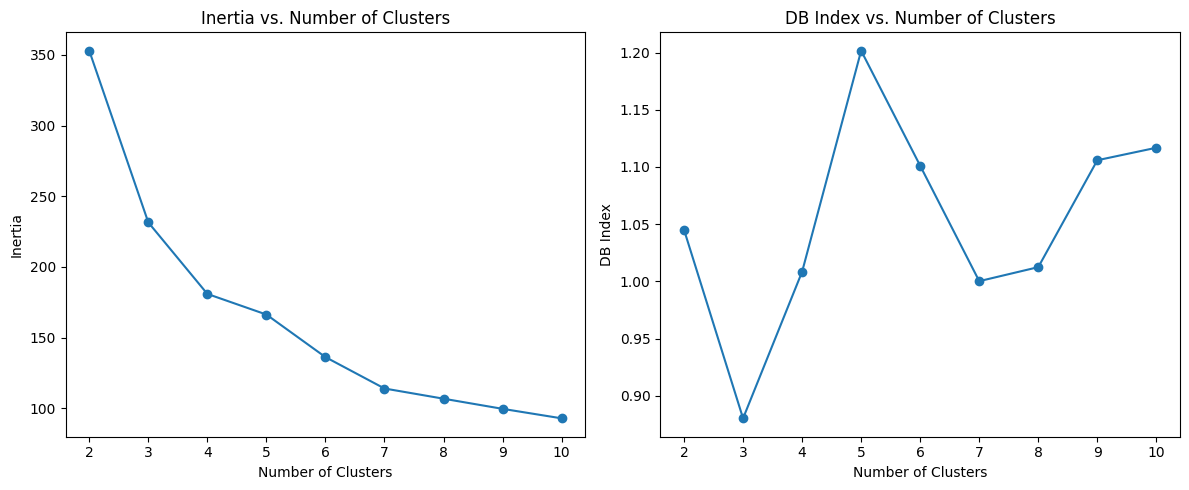

In [10]:
# Select features for clustering
features = customer_summary[['TotalSpent', 'PurchaseFrequency', 'Recency']]

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Determine the optimal number of clusters (2 to 10)
inertia = []
db_index = []

for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)
    db_index.append(davies_bouldin_score(features_scaled, kmeans.labels_))

# Plot the inertia and DB Index
plt.figure(figsize=(12, 5))

# Inertia plot
plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, marker='o')
plt.title('Inertia vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')

# DB Index plot
plt.subplot(1, 2, 2)
plt.plot(range(2, 11), db_index, marker='o')
plt.title('DB Index vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

plt.tight_layout()
plt.show()

In [11]:
# Fit the K-Means model with the chosen number of clusters
optimal_clusters = 4
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
customer_summary['Cluster'] = kmeans.fit_predict(features_scaled)

# Display the customer summary with cluster labels
print(customer_summary.head())

  CustomerID  TotalSpent  PurchaseFrequency    LastPurchaseDate  Recency  \
0      C0001     3354.52                  5 2024-11-02 17:04:16       84   
1      C0002     1862.74                  4 2024-12-03 01:41:41       54   
2      C0003     2725.38                  4 2024-08-24 18:54:04      154   
3      C0004     5354.88                  8 2024-12-23 14:13:52       33   
4      C0005     2034.24                  3 2024-11-04 00:30:22       83   

   Cluster  
0        3  
1        1  
2        1  
3        0  
4        1  


In [12]:
# Calculate the DB Index for the final clustering
db_index_final = davies_bouldin_score(features_scaled, customer_summary['Cluster'])
print(f'Davies-Bouldin Index for {optimal_clusters} clusters: {db_index_final}')

Davies-Bouldin Index for 4 clusters: 1.008401815490853


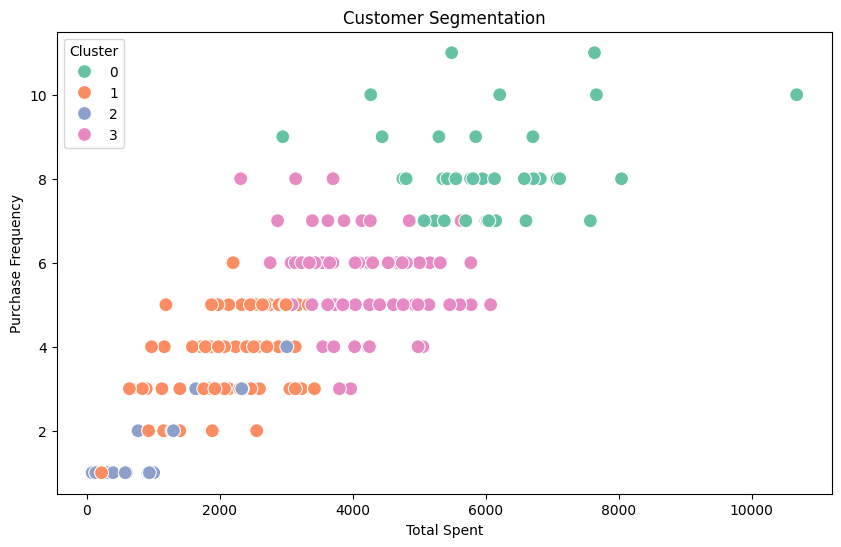

In [13]:
# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=customer_summary, x='TotalSpent', y='PurchaseFrequency', hue='Cluster', palette='Set2', s=100)
plt.title('Customer Segmentation')
plt.xlabel('Total Spent')
plt.ylabel('Purchase Frequency')
plt.legend(title='Cluster')
plt.show()

In [14]:
# Save the customer summary with cluster labels
customer_summary.to_csv('Customer_Segmentation.csv', index=False)

<ipython-input-15-a06f3483f4aa>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_summary, x='Cluster', y='TotalSpent', palette='Set2')


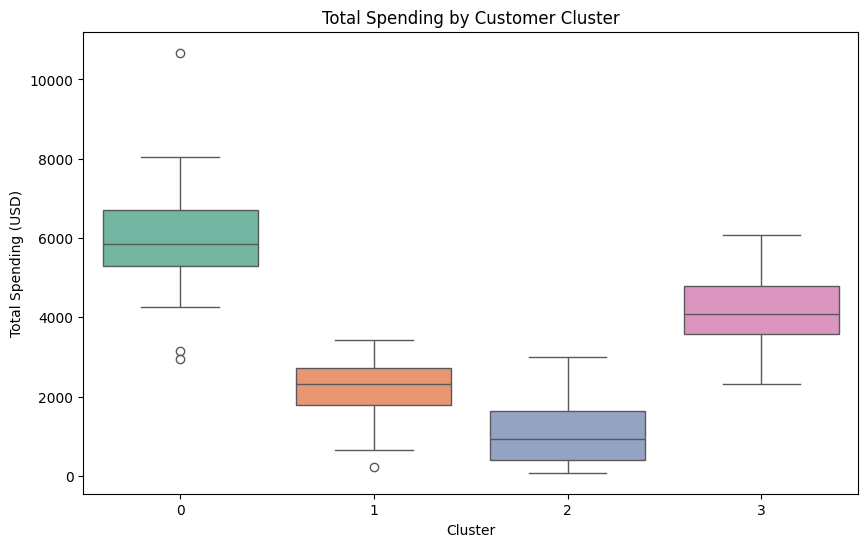

In [15]:
# 1. Box Plot of Total Spending by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=customer_summary, x='Cluster', y='TotalSpent', palette='Set2')
plt.title('Total Spending by Customer Cluster')
plt.xlabel('Cluster')
plt.ylabel('Total Spending (USD)')
plt.xticks(rotation=0)
plt.show()


<ipython-input-16-f4302037e494>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=customer_summary, x='Cluster', y='PurchaseFrequency', palette='Set2')


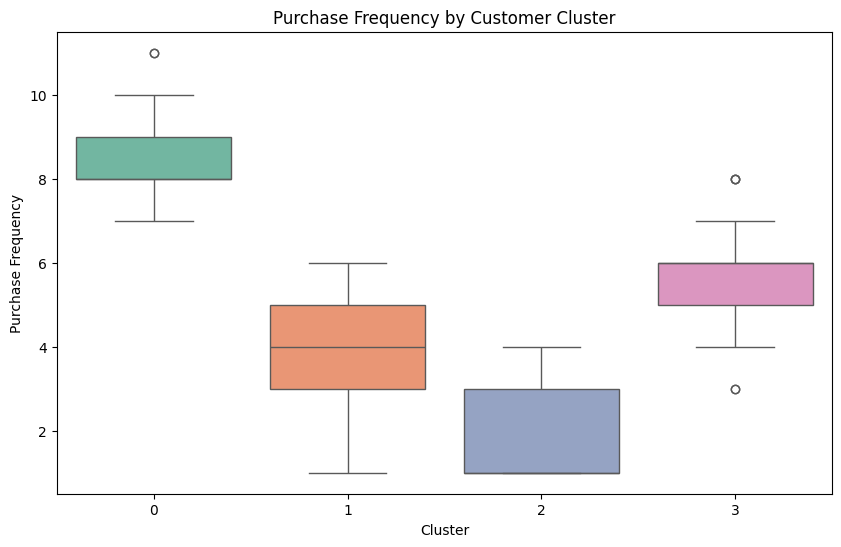

In [16]:
# 2. Box Plot of Purchase Frequency by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=customer_summary, x='Cluster', y='PurchaseFrequency', palette='Set2')
plt.title('Purchase Frequency by Customer Cluster')
plt.xlabel('Cluster')
plt.ylabel('Purchase Frequency')
plt.xticks(rotation=0)
plt.show()

<ipython-input-17-4f3127d487cc>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=customer_summary, x='Cluster', palette='Set2')


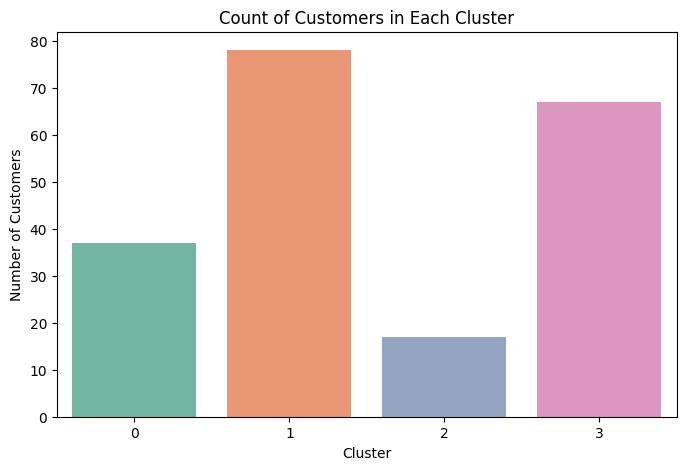

In [17]:
# 3. Count Plot of Clusters
plt.figure(figsize=(8, 5))
sns.countplot(data=customer_summary, x='Cluster', palette='Set2')
plt.title('Count of Customers in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
plt.show()

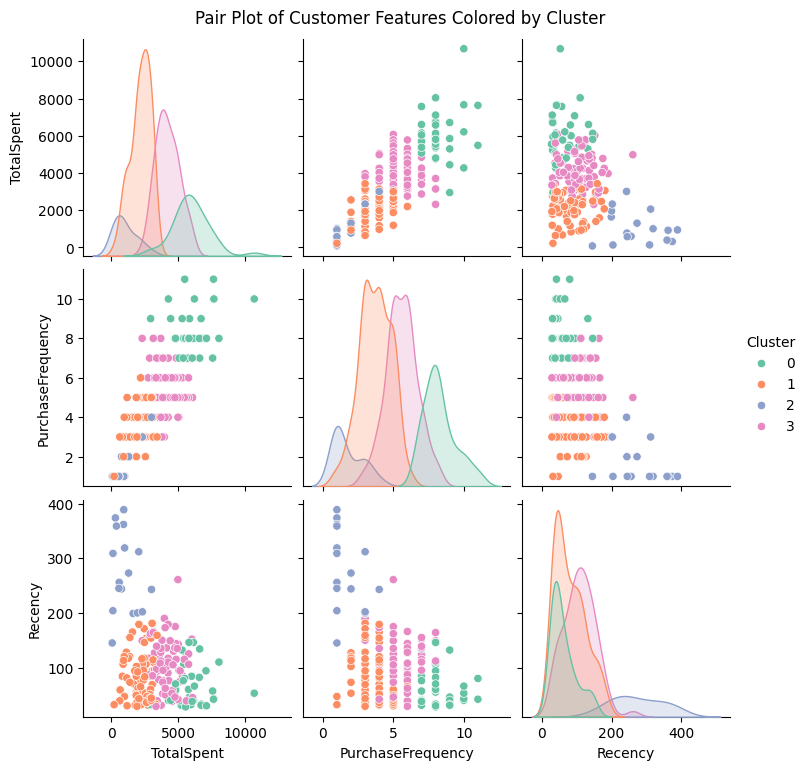

In [18]:
# 4. Pair Plot of Features Colored by Cluster
sns.pairplot(customer_summary, vars=['TotalSpent', 'PurchaseFrequency', 'Recency'], hue='Cluster', palette='Set2')
plt.suptitle('Pair Plot of Customer Features Colored by Cluster', y=1.02)
plt.show()